In [ ]:
"""
Loads two XDGMM models (one galaxies, one quasars)
Goes epoch by epoch and object by object to check the probability that they match their native model
Can also check probability that they belong to foreign model
"""

In [103]:
%matplotlib inline
import sklearn
import nose
import astroML_addons
import astroML
import scipy
import pandas
import xdgmm
from astropy.io import fits
import csv
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt

xdgmmG = xdgmm.XDGMM(filename='galaxyModel2018-03-28.fit') # your xdgmm models here

xdgmmQ = xdgmm.XDGMM(filename='notNullTrialset_feb15.fit')

print("Galaxy weights:")
print(xdgmmG.weights)
print("Quasar weights:")
print(xdgmmQ.weights)

Galaxy weights:
[  2.13736766e-01   2.44606923e-01   3.07442504e-02   2.16672443e-01
   1.31200648e-01   5.44694928e-03   1.75974297e-04   2.83076055e-02
   1.29108442e-01]
Quasar weights:
[ 0.35075201  0.16394932  0.32481524  0.0415381   0.11894532]


In [167]:
'''
method name: fetchValsByEpoch
purpose: takes information from csv files of galaxy/quasar objects and reads it into a set of arrays
args:
- epoch:epoch number (i.e. column in csv)
- directorystr: string name of directory (e.g. "/csvfiles/galaxies")
returns:
- deltaW: array of W1-W2 data
- sigW: array of the uncertainty on each deltaW value
- notNullCount: number of files that did not have a null in that epoch
- name: list of the names of all the objects
- mjd: list of the MJD dates of each object's epoch
'''

def fetchValsByEpoch(epoch, directorystr):
    
    deltaW = []
    sigW = []
    w1 = []
    w2 = []
    w1s = []
    w2s = []
    mjd = []
    name = []
    
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    print(len(filelist))
    readdata = np.zeros((22,len(filelist)+1)) #one big list to rule them all
    fileCount = 0 #to keep our place in each list as we go through the files
    blankCount = 0
    for file in filelist:
        filestr = os.fsdecode(file)
        if(filestr.endswith(".csv")):
            readfile = open(directorystr+filestr, 'r')
            reader = csv.reader(readfile)
            typeIndex = 0 #to iterate through the w1, w2, etc list
            nullCount = 0
            rowCount = 0
            
            for row in enumerate(reader):
                if rowCount < 5 or rowCount >= 14:
                    if rowCount == 0 and row[1][1] == "null|":
                        nullCount = nullCount + 1 #skip this file
                    rowCount = rowCount + 1
                    continue #skip the first and last rows
                try:
                    entry = row[1][epoch]
                except IndexError:
                    rowCount = rowCount + 1
                    continue
                try:
                    fentry = float(entry)
                    readdata[typeIndex][fileCount] = fentry
                except ValueError:
                    if entry != 'null': #this is a label; skip it
                        rowCount = rowCount + 1 #keep track of where we are in the file
                        continue #skip to next row, do not increment readdata row
                    else: #this file isn't useful
                        readdata[typeIndex][fileCount] = 99 # so it stands out
                        nullCount = nullCount + 1 #this is a null in W1 or W2. don't want this file
                rowCount = rowCount + 1 #move on to the next row in the file
                typeIndex = typeIndex + 1 #move to next row in the data array
            if nullCount == 0:
                fileCount = fileCount + 1 #overwrite if we found null in W1, W2.
                name.append(filestr)
                
                
    print("Error count: " + str(blankCount))    
    w1 = [round(float(x), 4) for x in readdata[1]]
    w2 = [round(float(x), 4) for x in readdata[3]]
    w1s = [round(float(x), 4) for x in readdata[2]]
    w2s = [round(float(x), 4) for x in readdata[4]]
    mjd = [float(x) for x in readdata[0]]
  
    deltaW = [x - y for x,y in zip(w1,w2)]
    sigW = [np.sqrt(sx**2 + sy**2) for sx,sy in zip(w1s, w2s)]

    deltaW = deltaW[:len(name)] #seems that we're sometimes appending an extra deltaW
    sigW = sigW[:len(name)] #but not keeping its name?
  
    return deltaW, sigW, len(name), name, mjd

'''
method name: checkProbsLows
purpose: scores W1-W2 values for objects against their native model, and flags those which are unusual.
args:
- epoch:
- modelone: 
- modeltwo:
- directorystr:
- groupmean:
returns:
- lowprobRADEC
- lowDeltaWs
- lowMjds
OR: nothing, if none found
'''

def checkProbsLows(epoch, modelone, modeltwo, directorystr, groupmean):

    result = fetchValsByEpoch(epoch, directorystr)
    deltaW = result[0]
    sigW = result[1]
    npoints = result[2]
    radec = result[3]
    mjd = result[4]
    print("length radec: " + str(len(radec)))
    print("length deltaW " + str(len(deltaW)))

    deltaW = np.array(deltaW)
    deltaW = deltaW.reshape(deltaW.shape[0], 1)

    sigW = np.array(sigW)
    sigW = sigW.reshape(sigW.shape[0], 1,1)

    tryProb = modelone.score_samples(deltaW, sigW)
    print("shape, length try prob: " + str(len(tryProb[0])))

    lowprob = [x for x in tryProb[0] if x > -4.91175034067 and x < -0.604] #the values defining the range of interest
    print("Length lowprob: " + str(len(lowprob)))
    lowprobRADEC = []
    lowDeltaWs = []
    lowSigWs = []
    lowMjds = []
    for lowval in lowprob:
        for val in tryProb[0]:
            if(val == lowval):
                for i, j in enumerate(tryProb[0]):
                    if j == val: 
                        if(len(deltaW[i])!=0):
                            if(deltaW[i][0] < groupmean): # > for galaxies
                                lowprobRADEC.append(radec[i])
                                lowDeltaWs.append(deltaW[i][0])
                                lowSigWs.append(sigW[i][0])
                                lowMjds.append(mjd[i])
                            else:
                                continue
                        else:
                            continue
                        
    if(len(lowDeltaWs) != 0):
        lowDeltaWs = np.array(lowDeltaWs)
        lowSigWs = np.array(lowSigWs)
        return lowprobRADEC, lowDeltaWs, lowMjds
        
    else:
        return


'''
method name: checkProbsAVG
purpose: finds the mean and standard deviation of the likelihood of objects matching a model
args:
- epoch: the epoch to check
- modelone: the xdgmm model that the files will be compared to
- modeltwo: legacy
- directorystr
returns:
- mean and standard deviation of the likelihood of the objects fitting modelone
'''    
    
def checkProbsAVG(epoch, modelone, modeltwo, directorystr):

    result = fetchValsByEpoch(epoch, directorystr)
    deltaW = result[0]
    sigW = result[1]
    npoints = result[2]
    radec = result[3]
    mjd = result[4]

    deltaW = np.array(deltaW)
    deltaW = deltaW.reshape(deltaW.shape[0], 1)

    sigW = np.array(sigW)
    sigW = sigW.reshape(sigW.shape[0], 1,1)

    tryProb = modelone.score_samples(deltaW, sigW)
    
    return np.mean(tryProb[0]), np.std(tryProb[0])



running
Epoch: 1
1095
Error count: 0
length radec: 537
length deltaW 537
shape, length try prob: 537
Length lowprob: 249
Epoch: 2
1095
Error count: 0
length radec: 525
length deltaW 525
shape, length try prob: 525
Length lowprob: 262
Epoch: 3
1095
Error count: 0
length radec: 530
length deltaW 530
shape, length try prob: 530
Length lowprob: 268
Epoch: 4
1095
Error count: 0
length radec: 532
length deltaW 532
shape, length try prob: 532
Length lowprob: 263
Epoch: 5
1095
Error count: 0
length radec: 549
length deltaW 549
shape, length try prob: 549
Length lowprob: 261
Epoch: 6
1095
Error count: 0
length radec: 533
length deltaW 533
shape, length try prob: 533
Length lowprob: 238
Epoch: 7
1095
Error count: 0
length radec: 551
length deltaW 551
shape, length try prob: 551
Length lowprob: 257
Epoch: 8
1095
Error count: 0
length radec: 553
length deltaW 553
shape, length try prob: 553
Length lowprob: 273
Epoch: 9
1095
Error count: 0
length radec: 550
length deltaW 550
shape, length try prob:

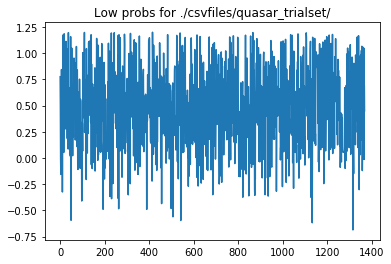

In [168]:
'''
-retrieves unusually low probability values
'''

print("running")
directorystr = './csvfiles/quasar_trialset/'
model = xdgmmQ #native model
model2 = xdgmmG #foreign model
groupmean = 1.2 #roughly, for quasars


lowProbVals = []
crossmodelprobs = []
names = []
lowDeltaWs = []
lowMjds = []
import subprocess

for epoch in range(1, 10):
    print("Epoch: " + str(epoch))
    result = checkProbsLows(epoch, model, model2, directorystr, groupmean)
    if(result):
        for i in result[0]:
            names.append(i)
        for i in result[1]:
            lowDeltaWs.append(i)
        for i in result[2]:
            lowMjds.append(i)
    
print(len(names))            

plt.plot(lowDeltaWs)
plt.title("Low probs for " + directorystr)

print("done.")
#not all files have the same number of observations


In [118]:
'''
-compares quasars to galaxy model to establish baseline for 'unusual'
'''

print("running")
directorystr = './csvfiles/quasar_trialset/'
model = xdgmmQ #native model
model2 = xdgmmG #foreign model

means = []
stds = []

for epoch in range(1, 40):
    result = checkProbsAVG(epoch, model2, model, directorystr)
    means.append(result[0])
    stds.append(result[1])
    
print("Avg. log prob: " + str(np.mean(means)))
print("Avg. std on log prob: " + str(np.mean(stds)))

running
Epoch: 1
1095
Error count: 0
Epoch: 2
1095
Error count: 0
Epoch: 3
1095
Error count: 0
Epoch: 4
1095
Error count: 0
Epoch: 5
1095
Error count: 0
Epoch: 6
1095
Error count: 0
Epoch: 7
1095
Error count: 0
Epoch: 8
1095
Error count: 0
Epoch: 9
1095
Error count: 0
Epoch: 10
1095
Error count: 0
Epoch: 11
1095
Error count: 0
Epoch: 12
1095
Error count: 0
Epoch: 13
1095
Error count: 0
Epoch: 14
1095
Error count: 0
Epoch: 15
1095
Error count: 0
Epoch: 16
1095
Error count: 0
Epoch: 17
1095
Error count: 0
Epoch: 18
1095
Error count: 0
Epoch: 19
1095
Error count: 0
Epoch: 20
1095
Error count: 0
Epoch: 21
1095
Error count: 0
Epoch: 22
1095
Error count: 0
Epoch: 23
1095
Error count: 0
Epoch: 24
1095
Error count: 0
Epoch: 25
1095
Error count: 0
Epoch: 26
1095
Error count: 0
Epoch: 27
1095
Error count: 0
Epoch: 28
1095
Error count: 0
Epoch: 29
1095
Error count: 0
Epoch: 30
1095
Error count: 0
Epoch: 31
1095
Error count: 0
Epoch: 32
1095
Error count: 0
Epoch: 33
1095
Error count: 0
Epoch: 34
1

In [120]:
'''
-compares galaxies to quasar model to establish baseline for 'unusual'
'''

print("running")
directorystr = './csvfiles/galaxy_trialset/'
model = xdgmmQ #native model
model2 = xdgmmG #foreign model

means = []
stds = []

for epoch in range(1, 38):
    result = checkProbsAVG(epoch, model, model2, directorystr)
    means.append(result[0])
    stds.append(result[1])
    
print("Avg. log prob: " + str(np.mean(means)))
print("Avg. std on log prob: " + str(np.mean(stds)))

running
Epoch: 1
967
Error count: 0
Epoch: 2
967
Error count: 0
Epoch: 3
967
Error count: 0
Epoch: 4
967
Error count: 0
Epoch: 5
967
Error count: 0
Epoch: 6
967
Error count: 0
Epoch: 7
967
Error count: 0
Epoch: 8
967
Error count: 0
Epoch: 9
967
Error count: 0
Epoch: 10
967
Error count: 0
Epoch: 11
967
Error count: 0
Epoch: 12
967
Error count: 0
Epoch: 13
967
Error count: 0
Epoch: 14
967
Error count: 0
Epoch: 15
967
Error count: 0
Epoch: 16
967
Error count: 0
Epoch: 17
967
Error count: 0
Epoch: 18
967
Error count: 0
Epoch: 19
967
Error count: 0
Epoch: 20
967
Error count: 0
Epoch: 21
967
Error count: 0
Epoch: 22
967
Error count: 0
Epoch: 23
967
Error count: 0
Epoch: 24
967
Error count: 0
Epoch: 25
967
Error count: 0
Epoch: 26
967
Error count: 0
Epoch: 27
967
Error count: 0
Epoch: 28
967
Error count: 0
Epoch: 29
967
Error count: 0
Epoch: 30
967
Error count: 0
Epoch: 31
967
Error count: 0
Epoch: 32
967
Error count: 0
Epoch: 33
967
Error count: 0
Epoch: 34
967
Error count: 0
Epoch: 35
967
E

In [169]:
'''
Saves the names of all the flagged objects in a file.
'''

f = open('quasarflags_3sigma.txt', 'w') # your filename here
for i in range(len(names)):
    f.write(names[i]+','+str(lowMjds[i])+'\n')
f.close()
print("Done")

Done
